# Thickness advection (층후 이류)
- https://unidata.github.io/python-training/gallery/differential_temperature_advection/ 를 참고하였음

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter

In [2]:
ds = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\OneDrive - SNU\2020-2\대기분석및실험\7주차\era5_pres_2020100300.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, level: 9, longitude: 1440, time: 2)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 200 300 400 500 600 700 800 925 1000
  * time       (time) datetime64[ns] 2020-10-03 2020-10-04
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-22 17:12:01 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [5]:
# Get time
itime = '2020-10-03'
ftime = '2020-10-04'

# Get lat/lon data from file
lats = ds.latitude.data[80:321]
lons = ds.longitude.data[240:801]

# Calculate variable dx, dy values for use in calculations
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Get variables and smooth

zi_500 = ds['z'].sel(time=itime, level=500, latitude=lats, longitude=lons)
zf_500 = ds['z'].sel(time=ftime, level=500, latitude=lats, longitude=lons)
zi_700 = ds['z'].sel(time=itime, level=700, latitude=lats, longitude=lons)
zi_1000 = ds['z'].sel(time=itime, level=1000, latitude=lats, longitude=lons)
thick_700 = ds['z'].sel(time=itime, level=700, latitude=lats, longitude=lons)
u_700 = ds['u'].sel(time=itime, level=700, latitude=lats, longitude=lons) 
v_700 = ds['v'].sel(time=itime, level=700, latitude=lats, longitude=lons)


zi_500, zf_500, zi_700, zi_1000, thick_700, u_700, v_700 = map(lambda x: mpcalc.smooth_n_point(x.squeeze(),9),\
                                                                       [zi_500, zf_500, zi_700, zi_1000, thick_700, u_700, v_700])

g = 9.806 * units('m/s**2')
zi_500, zi_700, zi_1000, zf_500 = map(lambda x: (x / g).to_base_units(), [zi_500, zi_700, zi_1000, zf_500])
thick_500_1000 = zi_500 - zi_1000


# Get time in a nice datetime object format
vtime = ds.time.values.astype('datetime64[ms]').astype('O')[0]

In [6]:
# Use MetPy advection function to calculate thickness advection

thick_adv_700 = mpcalc.advection(thick_700, (u_700, v_700),
                            (dx, dy), dim_order='yx').to_base_units() / g * 10**4


In [7]:
# Set up plot crs (mapcrs) and the data crs, will need to transform all variables
mapcrs = ccrs.LambertConformal(central_longitude=125, central_latitude=35,
                               standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

def ax_ccrs_set(ax):
    
    ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    
    return

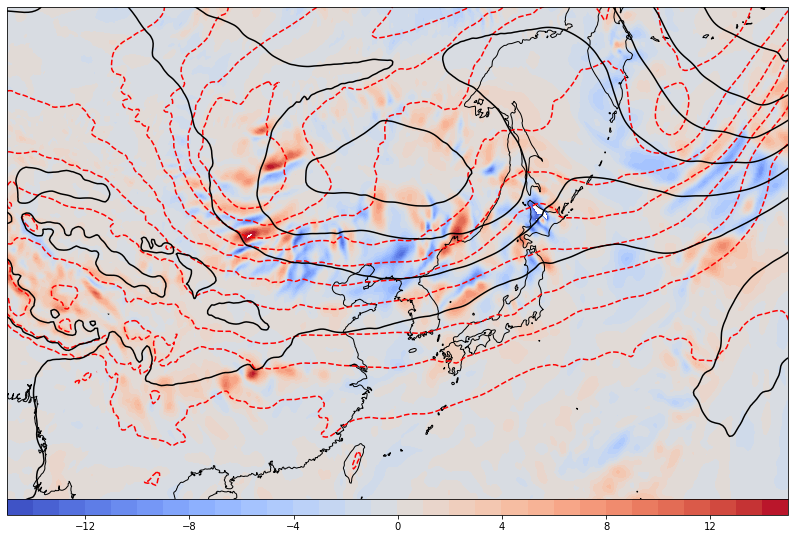

In [8]:
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax_ccrs_set(ax)
cs1 = ax.contour(lons, lats, thick_500_1000, np.arange(5000,6000,60), colors='red', linestyles='dashed', transform=datacrs)
cs2 = ax.contour(lons, lats, zi_700, np.arange(2400,3300,60), colors='black', linestyles='solid', transform=datacrs)
cf = ax.contourf(lons, lats, thick_adv_700, np.arange(-15,15.1,1), cmap=plt.cm.coolwarm, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
plt.show()

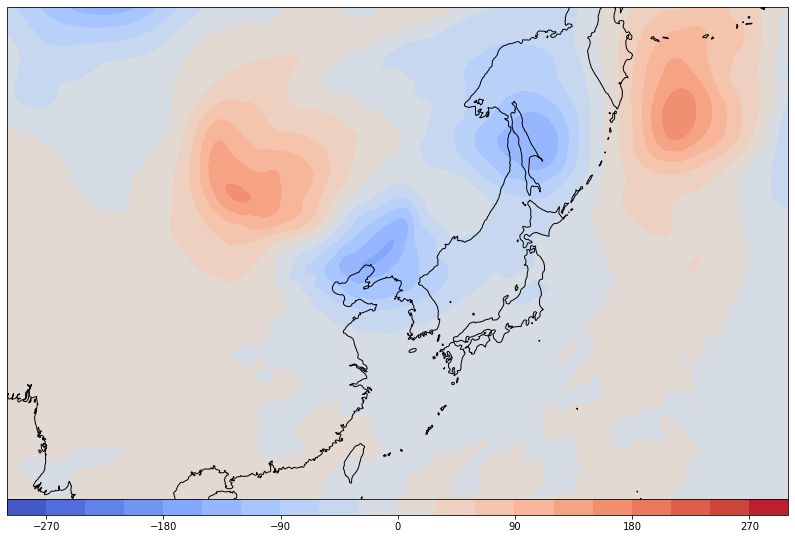

In [9]:
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax_ccrs_set(ax)
zdiff = zf_500 - zi_500
cf = ax.contourf(lons, lats, zdiff, np.arange(-300,301,30), cmap=plt.cm.coolwarm, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
plt.show()